# Load and analyze results from passive stimulus experiments

* Prior to receiving any behavior training, head fixed mice were exposed to three stimulus conditions in randomized order:
    * Full screen, square wave gratings, flashed for 200 ms ("visual" condition)
    * White noise bursts, 200 ms duration ("auditory" condition)
    * Concurrent gratings/white noise bursts ("visual_and_auditory" condition)
* Each experiment was 10-15 minutes in length with ~50 presentations per condition


## Imports
* Helper functions for this analysis are in ..utilities.helper_functions.py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

import seaborn as sns

import imageio

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import visual_behavior.plotting as vbp

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/dougo/.conda/envs/isxenv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
window_size = 1.5 # number of seconds before/after each stimulus event over which to integrate activity for the purpose of calling a cell 'responsive'
significance_level = 0.05 # level at which to declare a response 'significant'

## load summary data

In [4]:
data_path = os.path.join(os.path.split(os.getcwd())[0],'data')
session_list = pd.read_csv(os.path.join(os.path.join(data_path,'session_list.csv')))
passive_sessions = session_list.query('session_type == "passive"')
passive_sessions

,mouse_id,sex,genotype,AP_coord,ML_coord,DV_coord,session_type,recording_date,processing_date
8,M334410,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.5,passive,2017-10-27 10:57:47.469000,2018-12-14 01:47:16.329248905-08:00
9,M334412,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.7,passive,2018-02-21 17:36:40.068000,2019-01-12 04:17:24.670338392-08:00
10,M406494,F,Gnb4-IRES2-CreERT2/wt;Ai148(TIT2L-GC6f-ICL-tTA...,1.5,2.625,2.5,passive,2019-03-25 15:10:42.239000,2019-03-26 00:37:22.994131088-07:00
11,M332849,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,passive,2017-11-07 11:30:45.905000,2018-12-13 23:35:08.291905165-08:00
12,M397408,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,passive,2018-09-20 10:38:25.280000,2018-10-01 14:26:59.043725014-07:00
13,M375765,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,passive,2018-09-20 12:42:49.962000,2018-12-14 03:37:29.648535967-08:00
14,M416531,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,passive,2019-03-25 14:22:21.518000,2019-03-26 01:21:12.827245235-07:00
15,M432805,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.0,3.125,2.0,passive,2019-06-11 17:23:22,2019-06-12 12:44:31.709861040-07:00
16,M335379,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,3.125,2.5,passive,2017-10-24 15:57:58.264000,2018-12-14 02:24:22.327345610-08:00
17,M351181,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,passive,2018-02-16 12:48:23.809000,2018-12-14 00:12:11.677001715-08:00


In [5]:
cols_to_display = ['genotype','mouse_id','AP_coord', 'ML_coord', 'DV_coord','sex']
passive_sessions[cols_to_display].to_csv('/home/dougo/tbd_imaging_mouse_list_2020.09.22.csv', index=False)

In [6]:
passive_sessions['genotype'].value_counts()

Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    5
Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt    2
Gnb4-IRES2-Cre;AAV-GCaMP6s                                   2
Gnb4-IRES2-CreERT2/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt          1
Name: genotype, dtype: int64

### load each mouse's session data into a dictionary called 'session' with mouse_id as key

In [7]:
session = {}
for idx,row in passive_sessions.iterrows():
    session[row['mouse_id']] = helper_functions.load_session(row['mouse_id'], session_type='passive')
    print('on session {} of {}'.format(idx+1,len(passive_sessions)),end='\r')

### Look at some example cells:

#### a cell with a high SNR

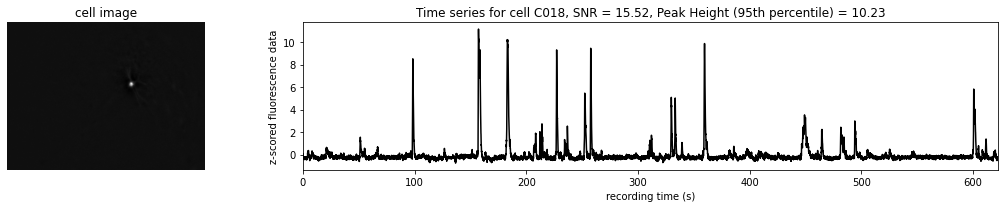

In [8]:
mouse = 'M351181'
cell = 'C018'
helper_functions.plot_cell(session[mouse],cell,timeseries_type='filtered')

#### a cell with a low SNR but a large peaks (the detected events from the Inscopix event detection algorithm don't correspond to the peaks)

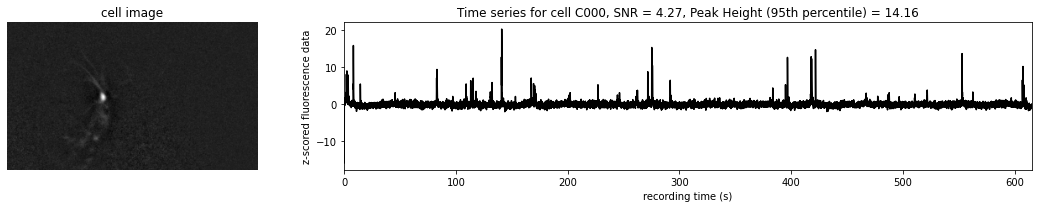

In [9]:
mouse = 'M432805'
cell = 'C000'
helper_functions.plot_cell(session[mouse],cell)

#### a cell with low SNR

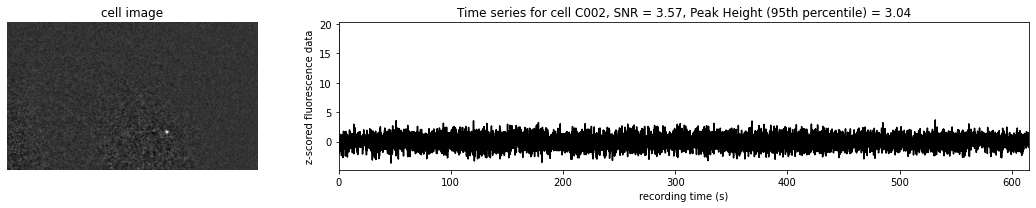

In [10]:
mouse = 'M432805'
cell = 'C002'
helper_functions.plot_cell(session[mouse],cell,timeseries_type='filtered')

#### However, even an SNR near 3 doesn't guarantee clean calcium transients.

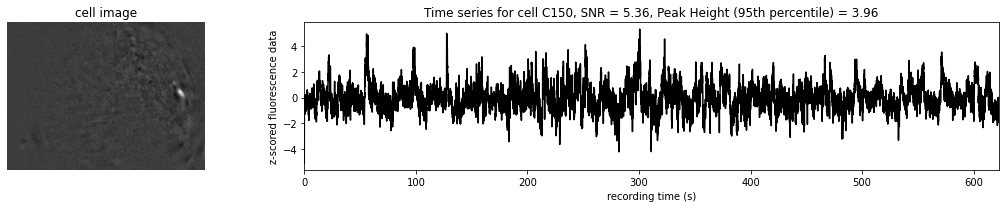

In [11]:
mouse = 'M351181'
cell = 'C150'
helper_functions.plot_cell(session[mouse],cell,timeseries_type='filtered')

### I'm also filtering out cells that look to be repeats due to over-segmentation
Here are some examples. In both cases, only the cell with the higher SNR is retained.

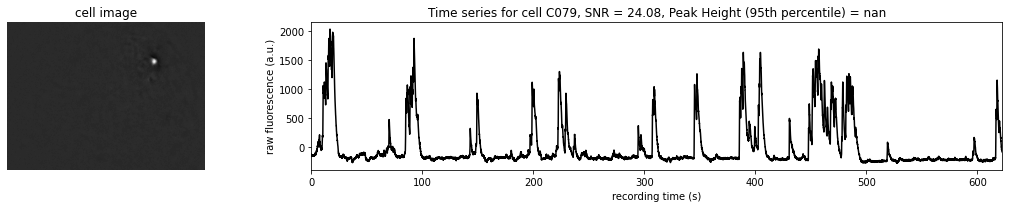

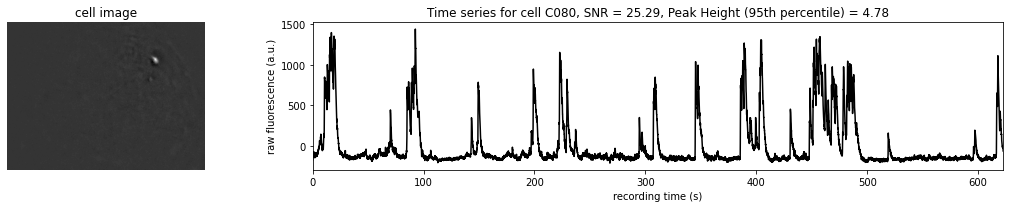

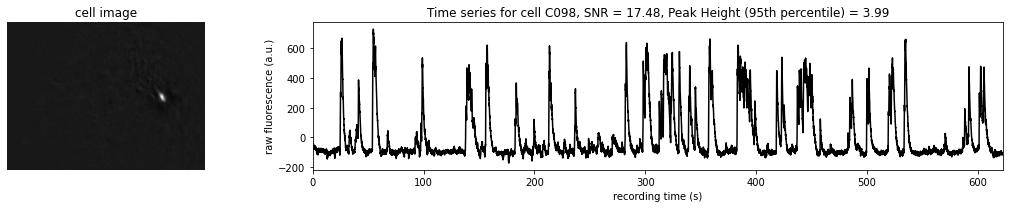

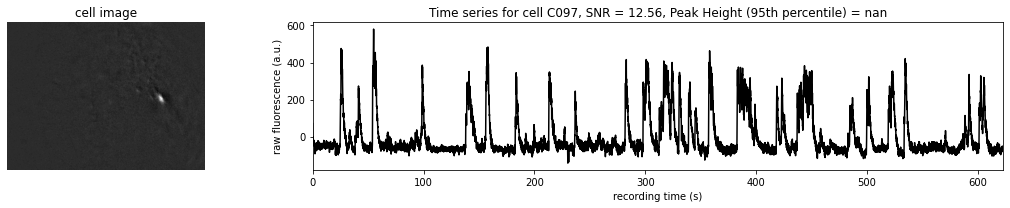

In [12]:
mouse = 'M351181'
helper_functions.plot_cell(session[mouse],cell='C079',timeseries_type='raw')
helper_functions.plot_cell(session[mouse],cell='C080',timeseries_type='raw')

helper_functions.plot_cell(session[mouse],cell='C098',timeseries_type='raw')
helper_functions.plot_cell(session[mouse],cell='C097',timeseries_type='raw')

### Here is the summary of sessions and cell counts before/after filtering (sessions with incomplete data aren't included)

In [13]:
passive_sessions['cell_count'] = passive_sessions['mouse_id'].map(lambda mouse: session[mouse].filtered_cell_count)
passive_sessions

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,mouse_id,sex,genotype,AP_coord,ML_coord,DV_coord,session_type,recording_date,processing_date,cell_count
8,M334410,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.5,passive,2017-10-27 10:57:47.469000,2018-12-14 01:47:16.329248905-08:00,69
9,M334412,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.7,passive,2018-02-21 17:36:40.068000,2019-01-12 04:17:24.670338392-08:00,144
10,M406494,F,Gnb4-IRES2-CreERT2/wt;Ai148(TIT2L-GC6f-ICL-tTA...,1.5,2.625,2.5,passive,2019-03-25 15:10:42.239000,2019-03-26 00:37:22.994131088-07:00,19
11,M332849,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,passive,2017-11-07 11:30:45.905000,2018-12-13 23:35:08.291905165-08:00,11
12,M397408,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,passive,2018-09-20 10:38:25.280000,2018-10-01 14:26:59.043725014-07:00,17
13,M375765,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,passive,2018-09-20 12:42:49.962000,2018-12-14 03:37:29.648535967-08:00,10
14,M416531,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,passive,2019-03-25 14:22:21.518000,2019-03-26 01:21:12.827245235-07:00,61
15,M432805,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.0,3.125,2.0,passive,2019-06-11 17:23:22,2019-06-12 12:44:31.709861040-07:00,46
16,M335379,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,3.125,2.5,passive,2017-10-24 15:57:58.264000,2018-12-14 02:24:22.327345610-08:00,127
17,M351181,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,passive,2018-02-16 12:48:23.809000,2018-12-14 00:12:11.677001715-08:00,115


## for each session, calculate responsiveness data for each accepted cell
extract the integral of the z-scored response in the <responsiveness_window> second(s) before and after each stimulus presentation

In [14]:
mice = session.keys()
for mouse_id in mice:
    session[mouse_id].responsiveness_data = helper_functions.get_responsiveness_data(session[mouse_id], window_size=window_size, behavior_condition='passive')

/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), int(frame_before+frame_after)))*np.NAN


In [15]:
mouse_id = 'M335379'
session[mouse_id].responsiveness_data.sample(15,random_state=0).set_index('cell_id')

,stim_condition,presentation_number,pre_stim_integral,post_stim_integral,pre_stim_mean,post_stim_mean
cell_id,,,,,,
C111,auditory,35,-11.191649,-14.571896,-0.385197,-0.504501
C079,auditory,29,-49.066474,86.058880,-1.691775,2.920910
C113,auditory_and_visual,0,20.786558,-18.391853,0.718563,-0.635617
C048,visual,40,-3.876635,-11.163427,-0.133426,-0.388447
C090,auditory_and_visual,49,4.179199,-14.391108,0.138169,-0.480790
C117,auditory_and_visual,37,-7.429160,2.461002,-0.257286,0.076695
C022,auditory_and_visual,41,-16.528429,-14.722802,-0.565346,-0.504837
C101,visual,50,50.226391,83.701309,1.752890,2.869650
C046,auditory_and_visual,4,-2.580362,-9.900994,-0.095429,-0.332821


## for each session, build responsiveness summary for each accepted cell
For each cell:
* build a distribution of post-stimulus response magnitudes for a given stimulus condition
* build a distribution of pre-stimulus response magnitutes for *every* stimulus condition
* test the hypothesis that these distributions are different (i.e., a cells calcium activity in the 1 second following the stimulus differs from its activity in the spontaneous state) using an independent t-test 
    * save the p-value for each comparison

In [16]:
for mouse_id in mice:
    session[mouse_id].responsiveness_summary = helper_functions.build_responsiveness_summary(session[mouse_id], window_size=window_size)

In [17]:
mouse_id = 'M375765'
session[mouse_id].responsiveness_summary.sort_values(by='p-value_on_integrals').head(10)

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means
20,C009,M375765,auditory_and_visual,53,-2.960351,11.513711,0.000009,1.0,-0.100674,0.379382,0.000014,1.0
19,C009,M375765,auditory,46,-2.960351,5.852454,0.001964,1.0,-0.100674,0.190052,0.002515,1.0
22,C010,M375765,auditory,46,-3.318030,6.603824,0.004598,1.0,-0.112675,0.219538,0.005481,1.0
23,C010,M375765,auditory_and_visual,53,-3.318030,4.920530,0.016368,1.0,-0.112675,0.162990,0.018919,1.0
25,C012,M375765,auditory,46,-1.649541,6.463266,0.016572,1.0,-0.056016,0.220166,0.017366,1.0
17,C006,M375765,auditory_and_visual,53,2.111217,-4.581228,0.027169,-1.0,0.071459,-0.154162,0.029709,-1.0
16,C006,M375765,auditory,46,2.111217,-3.686151,0.071983,-1.0,0.071459,-0.120605,0.081554,-1.0
27,C013,M375765,visual,48,0.475435,-3.485366,0.250452,-1.0,0.018383,-0.119831,0.241873,-1.0
14,C005,M375765,auditory_and_visual,53,-0.026384,-3.597942,0.291398,-1.0,-0.001029,-0.126426,0.278556,-1.0
11,C004,M375765,auditory_and_visual,53,0.769523,-2.376559,0.307234,-1.0,0.026755,-0.082233,0.305245,-1.0


/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), int(frame_before+frame_after)))*np.NAN


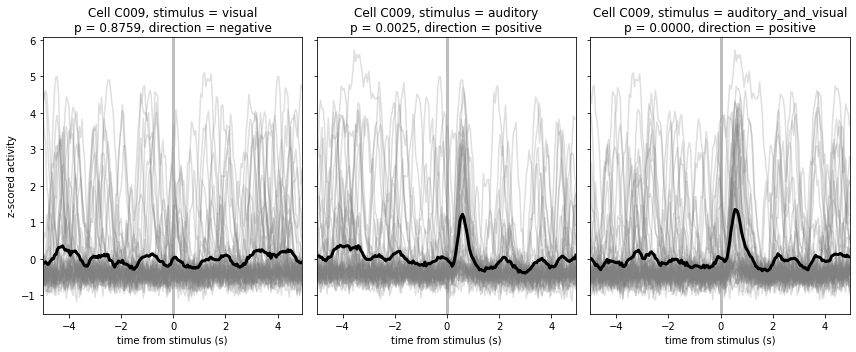

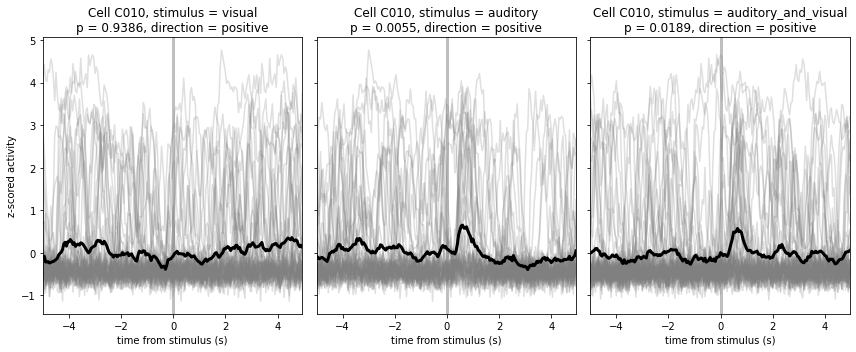

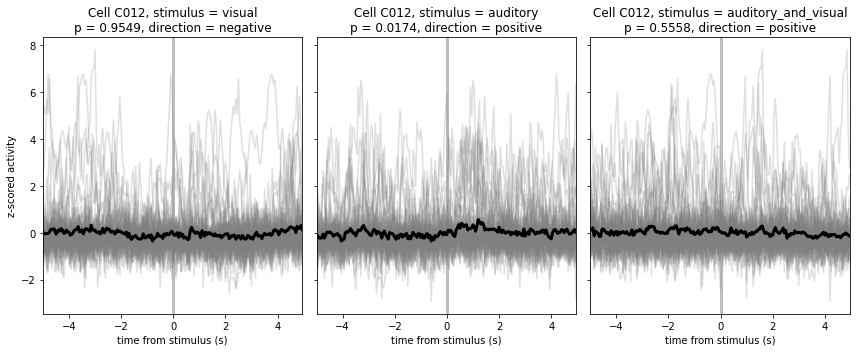

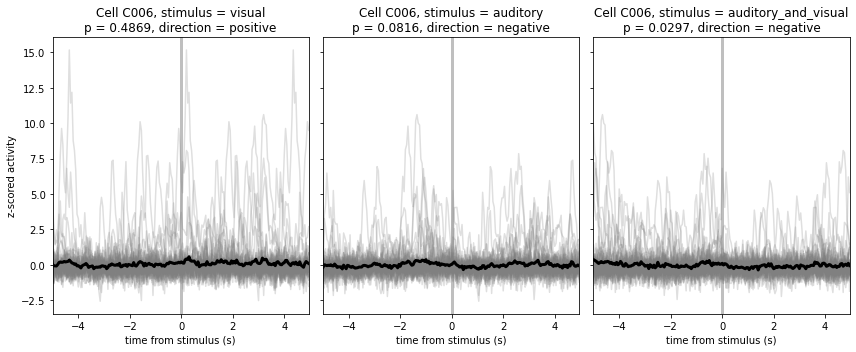

In [18]:
mouse_id = 'M375765'
helper_functions.plot_cells_with_significant_responses(session[mouse_id]);

## Here's an example of how the significance calculation works:

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


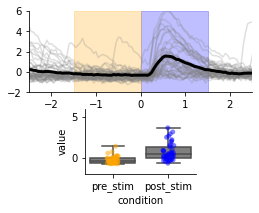

In [19]:
fig=plt.figure(figsize=(4,3))
ax = []
ax.append(vbp.placeAxesOnGrid(xspan = (0,1),yspan=(0,0.5),fig=fig))
ax.append(vbp.placeAxesOnGrid(xspan = (0.25,0.75),yspan=(0.6,1),fig=fig))

window_size = window_size

passive_stim_trials = session['M334410'].trials
stim_condition = 'auditory'
dat = helper_functions.get_responses(
    session['M334410'],
    'C071',
    passive_stim_trials[passive_stim_trials['stim_type'] == stim_condition]['nearest_F_frame']
)

pre_stim_indices = np.where(np.logical_and(dat['t']>=-window_size,dat['t']<0))
post_stim_indices = np.where(np.logical_and(dat['t']>0,dat['t']<=window_size))

pre_stims = []
post_stims = []
for idx in range(len(dat['all_traces'])):
    pre_stims.append(np.mean(dat['all_traces'][idx][pre_stim_indices]))
    post_stims.append(np.mean(dat['all_traces'][idx][post_stim_indices]))
    
df = pd.DataFrame({
    'value':pre_stims+post_stims,
    'condition':['pre_stim']*len(pre_stims) + ['post_stim']*len(post_stims)
})


helper_functions.plot_event_triggered_timeseries(dat,ax=ax[0])
ax[0].axvspan(-window_size,0,color='orange',alpha=0.25)
ax[0].axvspan(0,window_size,color='blue',alpha=0.25,zorder=-1)
ax[0].set_xlim(-2.5,2.5)

c=sns.stripplot(
    x='condition',
    y='value',
    data=df,
    ax=ax[1],
    palette=sns.color_palette(['orange', 'blue']),
    alpha=0.5
)
b=sns.boxplot(
    x='condition',
    y='value',
    data=df,
    ax=ax[1],
    palette=sns.color_palette(['gray','gray']),
    whis=np.inf
);
ax[0].set_ylim(-2,6)
ax[1].set_ylim(-2,6)


sns.despine()
fig.tight_layout()



#### How dependent is the significance value on the size of the window?
Look at four cells for mouse 375765

/home/dougo/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:557: RuntimeWarning: invalid value encountered in less_equal
  ax.plot(window_sizes[p_vals<=0.05],p_vals[p_vals<=0.05],'.r')
/home/dougo/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:557: RuntimeWarning: invalid valu

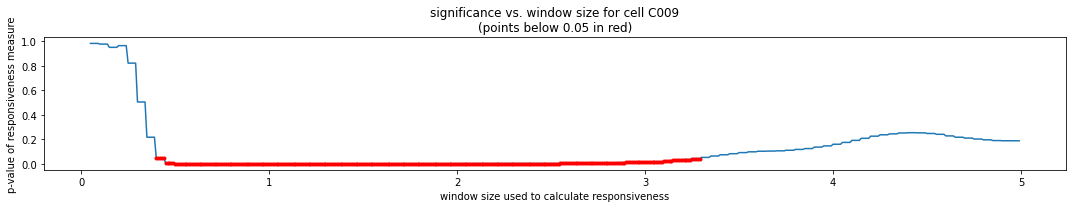

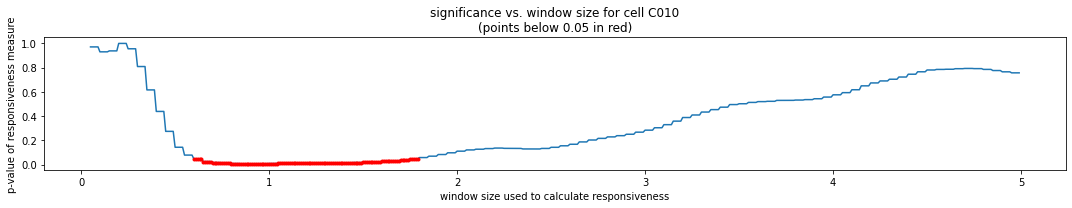

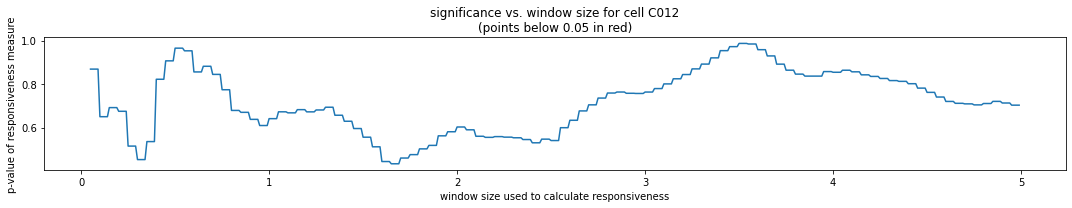

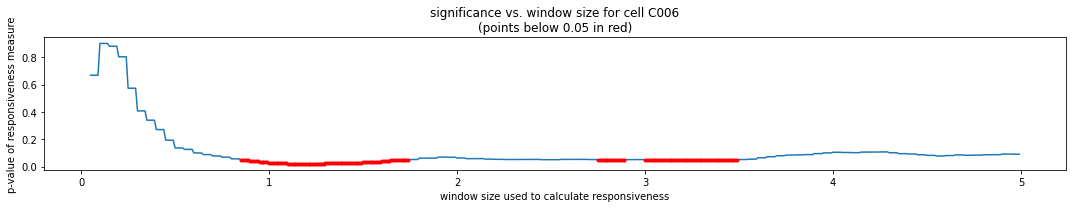

In [20]:
mouse_id = 'M375765'
for cell_id in ['C009','C010','C012','C006']:
    fig,ax=helper_functions.plot_significance_vs_window_size(mouse_id,cell_id,session,metric='mean')

## what is the overall fraction of responsive cells?

In [21]:
passive_sessions.set_index('mouse_id',inplace=True)
for mouse_id in mice:
    session[mouse_id].responsive_cells = {}
    responsive_cells = helper_functions.get_cells_with_significant_responses(session[mouse_id], significance_level=significance_level)
    passive_sessions.at[mouse_id,'number_of_responsive_cells'] = len(responsive_cells)
    passive_stim_trials = session[mouse_id].trials
    for cell_id in responsive_cells:
        session[mouse_id].responsive_cells[cell_id] = {}
        for col,condition in enumerate(['visual','auditory','auditory_and_visual']):
            dat = helper_functions.get_responses(
                session[mouse_id],
                cell_id,
                passive_stim_trials[passive_stim_trials['stim_type'] == condition]['nearest_F_frame']
            )
            d = {'trial_{:0>2d}'.format(i):arr for i,arr in enumerate(dat['all_traces'])}
            d['t'] = dat['t']
            session[mouse_id].responsive_cells[cell_id][condition] = pd.DataFrame(d).set_index('t')
    
    
def get_fraction_responsive(row):
    return row['number_of_responsive_cells']/row['cell_count']
passive_sessions['fraction_responsive_cells'] = passive_sessions.apply(get_fraction_responsive, axis=1)

/home/dougo/.local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dougo/.local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), 

In [22]:
cols_to_display = ['cell_count','number_of_responsive_cells','fraction_responsive_cells']
passive_sessions[cols_to_display]

,cell_count,number_of_responsive_cells,fraction_responsive_cells
mouse_id,,,
M334410,69,14.0,0.202899
M334412,144,1.0,0.006944
M406494,19,0.0,0.000000
M332849,11,1.0,0.090909
M397408,17,2.0,0.117647
M375765,10,4.0,0.400000
M416531,61,8.0,0.131148
M432805,46,3.0,0.065217
M335379,127,11.0,0.086614


## make some summary plots

#### lump cells together, make an overall summary plot

In [23]:
mice

dict_keys(['M334410', 'M334412', 'M406494', 'M332849', 'M397408', 'M375765', 'M416531', 'M432805', 'M335379', 'M351181'])

In [24]:
responsiveness_summary_all = [pd.DataFrame()]
responsiveness_data_all = [pd.DataFrame()]
for mouse_id in mice:    
    mouse_summary = session[mouse_id].responsiveness_summary
    mouse_summary['mouse_id'] = mouse_id
    responsiveness_summary_all.append(mouse_summary)
    
responsiveness_summary_all = pd.concat(responsiveness_summary_all)

def make_unique_cell_id(row):
    return row['mouse_id'] + '_' + row['cell_id']
responsiveness_summary_all['unique_cell_id'] = responsiveness_summary_all.apply(make_unique_cell_id,axis=1)

In [25]:
responsiveness_summary_all['integral_change_magnitude'] = responsiveness_summary_all['post_stim_integral_mean'] - responsiveness_summary_all['pre_stim_integral_mean']
responsiveness_summary_all['mean_change_magnitude'] = responsiveness_summary_all['post_stim_mean_all'] - responsiveness_summary_all['pre_stim_mean_all']

In [26]:
responsiveness_summary_all.head()

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,unique_cell_id,integral_change_magnitude,mean_change_magnitude
0,C000,M334410,visual,48,1.898550,0.051732,0.635677,-1.0,0.066934,0.002828,0.636036,-1.0,M334410_C000,-1.846818,-0.064106
1,C000,M334410,auditory,45,1.898550,-3.349861,0.155327,-1.0,0.066934,-0.113877,0.158483,-1.0,M334410_C000,-5.248411,-0.180811
2,C000,M334410,auditory_and_visual,57,1.898550,-0.810889,0.442163,-1.0,0.066934,-0.025634,0.450141,-1.0,M334410_C000,-2.709438,-0.092567
3,C001,M334410,visual,48,0.746454,2.100749,0.809431,1.0,0.023552,0.072012,0.799755,1.0,M334410_C001,1.354295,0.048460
4,C001,M334410,auditory,45,0.746454,-2.576795,0.519665,-1.0,0.023552,-0.088621,0.521200,-1.0,M334410_C001,-3.323249,-0.112173


In [27]:
responsiveness_summary_all['mean_change_magnitude'].describe()

count    1857.000000
mean       -0.004192
std         0.124646
min        -0.415598
25%        -0.081974
50%        -0.009931
75%         0.060821
max         0.956843
Name: mean_change_magnitude, dtype: float64

In [28]:
responsiveness_summary_all.query('condition=="auditory"')

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,unique_cell_id,integral_change_magnitude,mean_change_magnitude
1,C000,M334410,auditory,45,1.898550,-3.349861,0.155327,-1.0,0.066934,-0.113877,0.158483,-1.0,M334410_C000,-5.248411,-0.180811
4,C001,M334410,auditory,45,0.746454,-2.576795,0.519665,-1.0,0.023552,-0.088621,0.521200,-1.0,M334410_C001,-3.323249,-0.112173
7,C002,M334410,auditory,45,0.860819,-2.413614,0.467025,-1.0,0.029411,-0.081526,0.474912,-1.0,M334410_C002,-3.274433,-0.110936
10,C003,M334410,auditory,45,0.404941,-2.981398,0.334566,-1.0,0.015607,-0.100128,0.342965,-1.0,M334410_C003,-3.386339,-0.115736
13,C004,M334410,auditory,45,0.188414,-4.355386,0.224708,-1.0,0.005422,-0.149358,0.224650,-1.0,M334410_C004,-4.543800,-0.154780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,C160,M351181,auditory,43,0.038023,0.707417,0.857001,1.0,0.001143,0.020744,0.877972,1.0,M351181_C160,0.669394,0.019601
334,C166,M351181,auditory,43,2.257355,2.439667,0.954801,1.0,0.076480,0.084223,0.943961,1.0,M351181_C166,0.182311,0.007743
337,C170,M351181,auditory,43,0.513847,-1.971954,0.546744,-1.0,0.015837,-0.069172,0.549240,-1.0,M351181_C170,-2.485801,-0.085009
340,C172,M351181,auditory,43,2.617810,-3.610209,0.083113,-1.0,0.089476,-0.123823,0.084238,-1.0,M351181_C172,-6.228018,-0.213299


In [29]:
responsiveness_summary_all.query('condition=="auditory_and_visual"')

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,unique_cell_id,integral_change_magnitude,mean_change_magnitude
2,C000,M334410,auditory_and_visual,57,1.898550,-0.810889,0.442163,-1.0,0.066934,-0.025634,0.450141,-1.0,M334410_C000,-2.709438,-0.092567
5,C001,M334410,auditory_and_visual,57,0.746454,1.051983,0.951644,1.0,0.023552,0.035726,0.943265,1.0,M334410_C001,0.305529,0.012174
8,C002,M334410,auditory_and_visual,57,0.860819,-2.534614,0.403560,-1.0,0.029411,-0.082031,0.427724,-1.0,M334410_C002,-3.395433,-0.111441
11,C003,M334410,auditory_and_visual,57,0.404941,0.263629,0.966204,-1.0,0.015607,0.012958,0.981783,-1.0,M334410_C003,-0.141312,-0.002650
14,C004,M334410,auditory_and_visual,57,0.188414,-2.593696,0.407092,-1.0,0.005422,-0.089172,0.408312,-1.0,M334410_C004,-2.782110,-0.094593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,C160,M351181,auditory_and_visual,62,0.038023,-4.001847,0.243127,-1.0,0.001143,-0.133915,0.256757,-1.0,M351181_C160,-4.039870,-0.135058
335,C166,M351181,auditory_and_visual,62,2.257355,-1.888968,0.144004,-1.0,0.076480,-0.064085,0.149406,-1.0,M351181_C166,-4.146323,-0.140565
338,C170,M351181,auditory_and_visual,62,0.513847,-2.559384,0.419791,-1.0,0.015837,-0.089719,0.419976,-1.0,M351181_C170,-3.073231,-0.105556
341,C172,M351181,auditory_and_visual,62,2.617810,-3.672370,0.055721,-1.0,0.089476,-0.123184,0.059310,-1.0,M351181_C172,-6.290180,-0.212661


In [30]:
significance_threshold=0.05
condition='auditory_and_visual'
significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
significant.mean()

0.05492730210016155

In [31]:
def plot_mod_index_hist(index_vals, significant, ax, bin_edges=np.arange(-1,1,0.05)):
    '''
    index_vals (array of float): values of the index you want to plot
    significant (array of bool): whether each index val is significant or not
    '''
    
    ax.hist([index_vals[significant],index_vals[~significant]], 
             color=['k','darkgrey'], edgecolor='None', stacked=True, 
             bins=bin_edges, rwidth=0.8, density=True)

def plot_response_histograms(ax=None, significance_threshold=0.05):
    '''
    ax should be a 1x3 array of axis handles if passed
    '''
    if ax is None:
        fig,ax=plt.subplots(1,3,figsize=(12,2),sharex=True, sharey=True)
    for ii,condition in enumerate(['visual','auditory','auditory_and_visual']):
        magnitude = responsiveness_summary_all.query('condition == @condition')['mean_change_magnitude']
        significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
        plot_mod_index_hist(
            magnitude,
            significant,
            ax[ii]
        )
        axins = inset_axes(ax[ii], width="40%", height="40%", loc=1)

        axins.pie(
            [significant.sum(),len(significant)-significant.sum()],
            colors=['black','gray'],
            labels=['','']
        )
        ax[ii].set_title('condition = {}\nfraction modulated cells: {:0.3f}'.format(condition,significant.mean()))
        ax[ii].set_xlabel('change in mean (z-score)', fontsize=16)
        ax[ii].set_xticks([-1, -0.5, 0, 0.5, 1])
        ax[ii].set_yticks([])
        print(condition,significant.mean())
    ax[0].set_ylabel('fraction')
    sns.despine()
    

visual 0.012924071082390954
auditory 0.035541195476575124
auditory_and_visual 0.05492730210016155


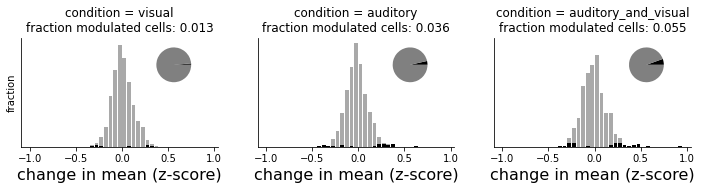

In [32]:
plot_response_histograms()

In [33]:
def plot_all(mouse_id,cell_id,ax=None, label_x=True, show_individual_traces=False):
    sess = session[mouse_id]
    if ax is None:
        fig,ax = plt.subplots(1,3,figsize=(8,4),sharex=True,sharey=True)

    titles = [
        'visual stimuli\np={:0.5f}',
        'auditory stimuli\np={:0.5f}',
        'visual+auditory stimuli\np={:0.5f}',
    ]

    rs = responsiveness_summary_all.query("mouse_id==@mouse_id and cell_id==@cell_id")[['condition','p-value_on_means']]

    passive_stim_trials = sess.trials
    for col,cond in enumerate(['visual','auditory','auditory_and_visual']):

        dat = helper_functions.get_responses(
            session[mouse_id],
            cell_id,
            passive_stim_trials[passive_stim_trials['stim_type'] == cond]['nearest_F_frame']
        )
        response_df = []
        for ii in range(np.shape(dat['all_traces'])[0]):
            df = pd.DataFrame({'t':dat['t'],'z_scored_activity':dat['all_traces'][ii]})
            df['condition'] = cond
            df['repeat_number'] = ii
            response_df.append(df)
        response_df = pd.concat(response_df)
        if show_individual_traces:
            ax[col] = vbp.plot_event_triggered_timeseries(
                dat,
                ax=ax[col],
                foreground_color='black',
            )
        else:
            sns.lineplot(
                data = response_df,
                x='t',
                y='z_scored_activity',
                ax = ax[col],
                color='black',
            )
        ax[col].axvline(0,color='k',linewidth=3,zorder=-np.inf,alpha=0.5)
        ax[col].set_xlim(-1.5,3)
        ax[col].set_title(titles[col].format(rs[rs['condition']==cond]['p-value_on_means'].item()))
        if col == 0:
            ax[col].set_ylabel('z-scored activity',fontsize=14)
        ax[col].set_yticklabels(ax[col].get_yticks(),fontsize=12)
        if label_x == False:
            ax[col].set_xticks([])
            ax[col].set_xticklabels([])
            ax[col].set_xlabel('')
        else:
            ax[col].set_xlabel('time from event (s)')

    sns.despine()

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


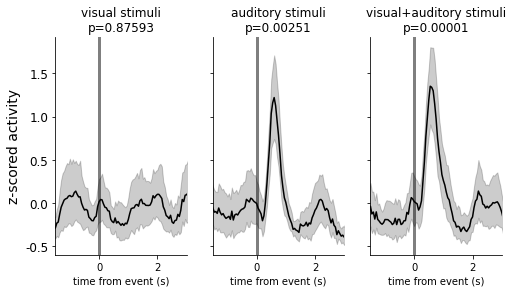

In [34]:
mouse = 'M375765'
cell_id = 'C009'
plot_all(mouse ,cell_id, label_x=True)

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


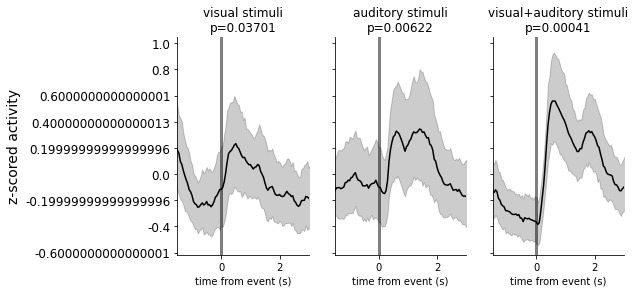

In [35]:
mouse = 'M351181'
cell_id = 'C104'
plot_all(mouse,cell_id)

In [36]:
responsiveness_summary_all[
    (responsiveness_summary_all['condition']=='auditory')
    &(responsiveness_summary_all['p-value_on_means']<significance_level)
]

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,unique_cell_id,integral_change_magnitude,mean_change_magnitude
16,C005,M334410,auditory,45,-1.942898,5.117109,1.930104e-02,1.0,-0.066439,0.172642,2.004293e-02,1.0,M334410_C005,7.060007,0.239081
22,C008,M334410,auditory,45,-2.129318,3.891273,4.482177e-02,1.0,-0.071210,0.136996,4.528959e-02,1.0,M334410_C008,6.020591,0.208207
28,C011,M334410,auditory,45,-2.916706,2.541159,4.486995e-02,1.0,-0.100002,0.084754,4.680615e-02,1.0,M334410_C011,5.457866,0.184756
94,C047,M334410,auditory,45,-5.492797,12.859002,3.086703e-07,1.0,-0.188876,0.428470,4.650463e-07,1.0,M334410_C047,18.351799,0.617346
139,C071,M334410,auditory,45,-7.334704,21.206982,2.351120e-14,1.0,-0.251742,0.705101,4.738861e-14,1.0,M334410_C071,28.541686,0.956843
145,C075,M334410,auditory,45,3.369222,-8.937524,8.677437e-03,-1.0,0.115805,-0.299793,9.879153e-03,-1.0,M334410_C075,-12.306745,-0.415598
163,C095,M334410,auditory,45,2.823904,-8.712308,9.891319e-03,-1.0,0.096902,-0.296900,1.055437e-02,-1.0,M334410_C095,-11.536212,-0.393801
184,C115,M334410,auditory,45,2.558649,-5.908439,2.382780e-02,-1.0,0.087017,-0.198577,2.648651e-02,-1.0,M334410_C115,-8.467089,-0.285594
172,C060,M334412,auditory,51,0.125019,10.519674,1.247823e-02,1.0,0.004189,0.362993,1.219231e-02,1.0,M334412_C060,10.394655,0.358804
10,C003,M332849,auditory,38,-0.699893,9.399167,3.430790e-02,1.0,-0.024201,0.316238,3.626954e-02,1.0,M332849_C003,10.099060,0.340438


In [37]:
def show_schematic(ax=None):
    if ax is None:
        fig,ax=plt.subplots()
    image = imageio.imread('passive_stim_schematic.png')
    # trim off black border on PNG
    ax.imshow(image[10:-10,10:-10,:],interpolation='nearest')
    ax.axis('off')

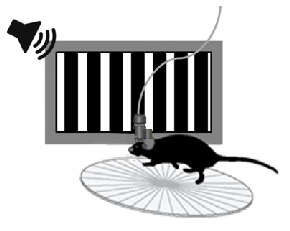

In [38]:
fig,ax=plt.subplots()
show_schematic(ax)

# Final Figure

In [39]:
%matplotlib inline

/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), int(frame_before+frame_after)))*np.NAN
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `item` has been deprecated and will be removed in a futur

visual 0.012924071082390954
auditory 0.035541195476575124
auditory_and_visual 0.05492730210016155


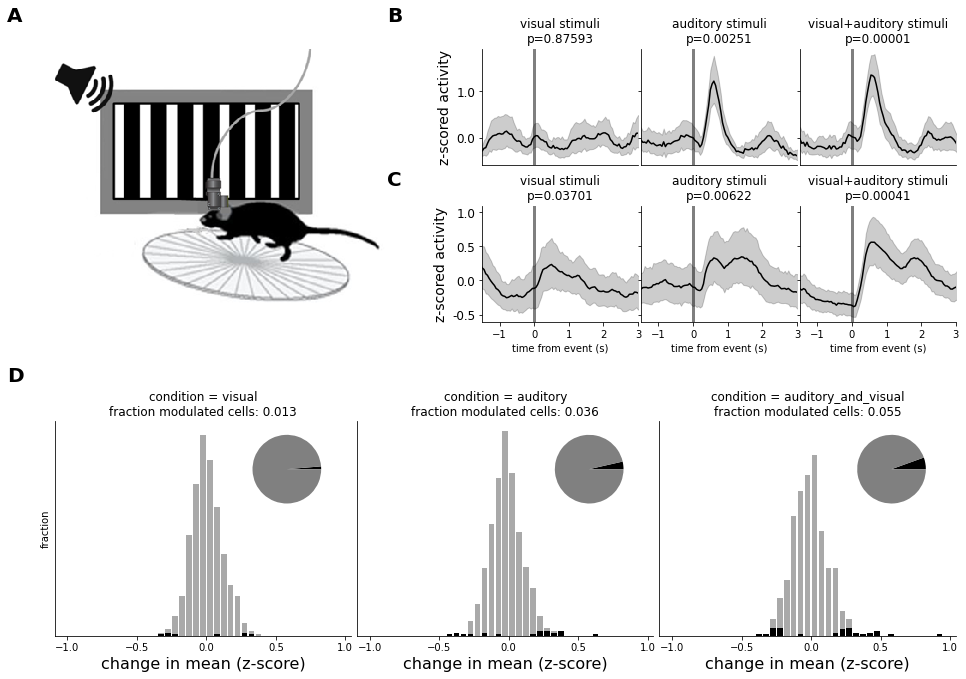

In [40]:
save_fig = True

figsize=(2*8.5,2*6)
figure_2 = plt.figure(figsize=figsize)
axes = {
    'A':plotting_utilities.placeAxesOnGrid(figure_2, xspan=[0.05,0.4], yspan=[0,0.6]),
    'B':plotting_utilities.placeAxesOnGrid(figure_2, xspan=[0.5,1],    yspan=[0.1,0.28],  dim=[1,3], sharex=True, sharey=True, wspace=0.02),
    'C':plotting_utilities.placeAxesOnGrid(figure_2, xspan=[0.5,1],    yspan=[0.34,0.52], dim=[1,3], sharex=True, sharey=True, wspace=0.02),
    'D':plotting_utilities.placeAxesOnGrid(figure_2, xspan=[0.05,1],   yspan=[0.67,1],    dim=[1,3], sharex=True, sharey=True, wspace=0.02),
}
    
show_schematic(axes['A'])
plot_all('M375765', cell_id='C009', ax=axes['B'], label_x=False)
plot_all('M351181', cell_id='C104', ax=axes['C'], label_x=True)
plot_response_histograms(axes['D'])

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.05},
    {'label_text':'B', 'xpos':0.4, 'ypos':0.05},
    {'label_text':'C', 'xpos':0.4, 'ypos':0.30},
    {'label_text':'D', 'xpos':0,   'ypos':0.60},
]
for label in labels:
    plotting_utilities.add_label(
        figure_2,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )

if save_fig:
    plotting_utilities.save_figure(figure_2, fname='figure_2', formats=['.png','.pdf'], size=figsize, dpi=500)

## Quantify fractions responsive

### first build a pivot table where each row is a unique cell and the columns are booleans for significant responses for each of the trial conditions

In [43]:
responsiveness_summary_all['is_significant'] = responsiveness_summary_all['p-value_on_means'] < significance_level
responsiveness_summary_all['unique_id'] = responsiveness_summary_all['mouse_id'] + '_' + responsiveness_summary_all['cell_id']
significance_by_condition = responsiveness_summary_all.pivot(index='unique_id', columns='condition',values='is_significant')
significance_by_condition.sample(5)

condition,auditory,auditory_and_visual,visual
unique_id,,,
M397408_C010,False,False,False
M334410_C020,False,False,False
M416531_C017,False,False,False
M416531_C013,False,True,False
M334412_C022,False,False,False


In [49]:
len(significance_by_condition)

619

In [50]:
significance_by_condition['visual'].sum()

8

In [52]:
significance_by_condition['auditory'].sum()

22

In [53]:
significance_by_condition['auditory_and_visual'].sum()

34

## Quantify overlap

### what fraction of auditory and visual are also auditory?

In [47]:
len(significance_by_condition[significance_by_condition['auditory_and_visual']]['auditory'])

34

In [45]:
significance_by_condition[significance_by_condition['auditory_and_visual']]['auditory'].sum()

6

In [44]:
significance_by_condition[significance_by_condition['auditory_and_visual']]['auditory'].mean()

0.17647058823529413

### what fraction of auditory and visual are also visual?

In [54]:
len(significance_by_condition[significance_by_condition['auditory_and_visual']]['visual'])

34

In [55]:
significance_by_condition[significance_by_condition['auditory_and_visual']]['visual'].sum()

1

In [61]:
significance_by_condition[significance_by_condition['auditory_and_visual']]['visual'].mean()

0.029411764705882353

## heatmaps of individual cells

In [40]:
def make_heatmaps(mouse_id, cell_id, save_or_show='save'):
    fig,ax = plt.subplots(1,3,figsize=(18,4))

    for col,stim_condition in enumerate(['visual','auditory','auditory_and_visual']):
        p_val = responsiveness_summary_all.query('mouse_id == @mouse_id and cell_id == @cell_id and condition == @stim_condition')['p-value_on_means'].iloc[0]
        title = 'condition = {}, p-value = {:0.4f}'.format(stim_condition, p_val)
        helper_functions.single_cell_heatmap(
            session = session[mouse_id],
            cell_id = cell_id,
            events = session[mouse_id].trials.query('stim_type == @stim_condition')['nearest_F_frame'],
            ax=ax[col],
            cbar = True,
            title=title
        )

    fig.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle('mouse_id = {}, cell_id = {}'.format(mouse_id, cell_id),fontweight='bold')
    if save_or_show == 'save':
        folder = os.path.join(os.getcwd(), 'single_cell_heatmaps')
        helper_functions.make_folder(folder)
        plotting_utilities.save_figure(fig, os.path.join(folder, 'mouse_{}_cell_{}'.format(mouse_id, cell_id)))
        fig.clf()

In [41]:
for idx,row in responsiveness_summary_all[responsiveness_summary_all['p-value_on_means'] < significance_level].drop_duplicates('unique_cell_id').sort_values(by='p-value_on_means').iterrows():
    make_heatmaps(mouse_id = row['mouse_id'], cell_id = row['cell_id'], save_or_show = 'save')

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>